In [1]:
# audio libraries
import librosa
import librosa.display
import IPython.display as ipd  # to display spectra

# system libraries
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# preprocessing
from sklearn.preprocessing import StandardScaler

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

In [2]:
### sns plot aesthetics
sns.set_style("dark")

In [3]:
# where are all the audio files?
DIR_ALL_AUDIO = './data/all'

# Table of contents

# -1 functions to be outsourced

In [4]:
# define color palette
def get_colorpalette(filepath):
    """
    returns a dictionary with the unique class names together
    with their associated colors. To be used for e.g. visualizations.
    filepath: path to meta data file within the repo, e.g.
    './data/UrbanSound8K/metadata/UrbanSound8K.csv'
    """
    import pandas as pd
    df_meta = pd.read_csv(filepath)
    return {cat:'color' for cat in df_meta['class'].unique()}

def get_filepaths_from_dir(directory):
    '''
    returns a list of all file paths stored in a directory
    '''
    files_path = [os.path.join(directory,x) for x in os.listdir(directory)]
    return files_path

def get_filenames_from_dir(directory):
    '''
    returns a list of all file names stored in a directory
    '''
    file_names = [x for x in os.listdir(directory)]
    return file_names

def get_class_from_meta(filepath, meta_df):
    """
    queries the dataframe of the meta csv for a filename, returns the class
    filepath: relative filepath to sound file
    """
    return meta_df[meta_df['slice_file_name']==os.path.basename(filepath)]['class'].values[0]

# 0. Inspect the database

In [5]:
# run this to store all paths to all audio files in a list
all_audio_path_list = get_filepaths_from_dir(DIR_ALL_AUDIO)
all_audio_filenames = get_filenames_from_dir(DIR_ALL_AUDIO)

### 0.1. Metadata

In [6]:
df_meta = pd.read_csv('./data/UrbanSound8K.csv')

In [7]:
df_meta[df_meta['class']=='jackhammer']

,slice_file_name,fsID,start,end,salience,fold,classID,class
171,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
172,103074-7-0-1.wav,103074,3.841279,7.841279,1,1,7,jackhammer
173,103074-7-0-2.wav,103074,4.341279,8.341279,1,1,7,jackhammer
174,103074-7-1-0.wav,103074,22.517317,26.517317,1,1,7,jackhammer
175,103074-7-1-1.wav,103074,23.017317,27.017317,1,1,7,jackhammer
...,...,...,...,...,...,...,...,...
8658,98859-7-2-1.wav,98859,10.374292,14.374292,1,9,7,jackhammer
8659,98859-7-2-2.wav,98859,10.874292,14.874292,1,9,7,jackhammer
8660,98859-7-2-3.wav,98859,11.374292,15.374292,1,9,7,jackhammer
8661,98859-7-2-4.wav,98859,11.874292,15.874292,1,9,7,jackhammer


What am I classifying? What are the unique values?

In [8]:
df_meta['class'].value_counts()

engine_idling       1000
air_conditioner     1000
dog_bark            1000
street_music        1000
drilling            1000
children_playing    1000
jackhammer          1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [9]:
df_meta['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

### Checking for class balancing and time duration of sound snippets

Creating another column for the duration of the sounds

In [10]:
df_meta['duration'] = df_meta['end'] - df_meta['start']

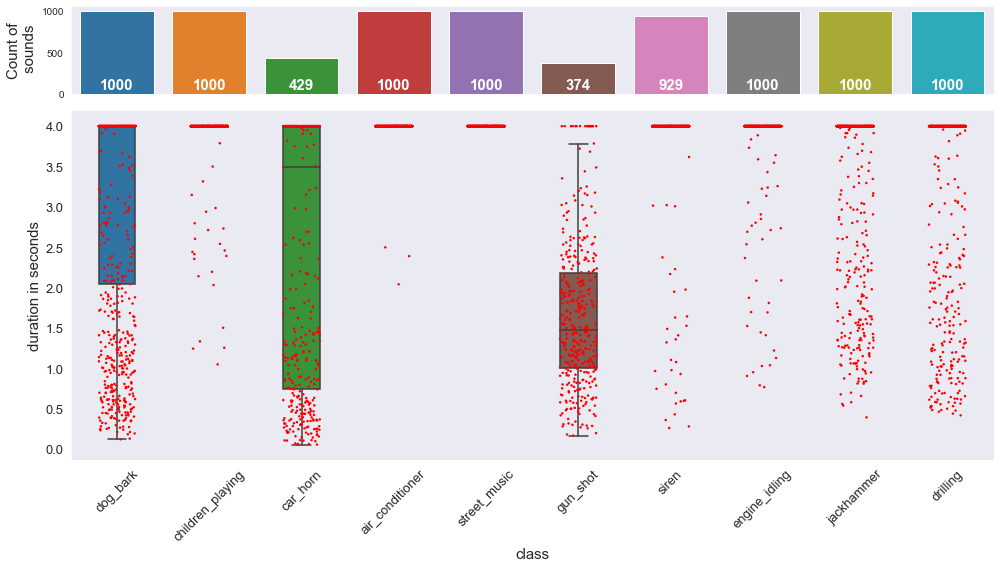

In [82]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8), gridspec_kw={'height_ratios': [1,4]})

# countplot on first row
sns.countplot(data=df_meta,
              x='class',
              ax=ax[0])
for p in ax[0].patches:
        ax[0].annotate('{:.0f}'.format(p.get_height()),
                       xy=(p.get_x() + p.get_width() / 2,
                           100),
                       ha='center',
                       va='center',
                       size=15,
                       color='white',
                       fontweight='bold')

ax[0].xaxis.set_visible(False)
ax[0].set_ylabel('Count of\n sounds', fontdict={"size":15})


# boxplot & stripplot on second row
sns.boxplot(data=df_meta,
            x='class',
            y='duration',
            showfliers=False,
            ax=ax[1],
            width=0.4,
           )

sns.stripplot(x='class',
              y='duration',
              data=df_meta,
              color="red",
              jitter=0.2,
              size=2.5,
              ax=ax[1],
             )
plt.ylabel('duration in seconds', fontdict={"size":15})
plt.xlabel('class', fontdict={"size":15})

plt.yticks(size=13);
plt.xticks(rotation=45, size=13);
plt.tight_layout()
# plt.title("Distribution of durations of soundfiles in the dataset per class", size=20)

Observations:
* Except `gun_shot` and `car_horn` all other target categories are fairly balanced

In [21]:
# number of uniqe classes
len(df_meta['class'].value_counts())

10

### Plotting frequency of duration of music files for different classes.

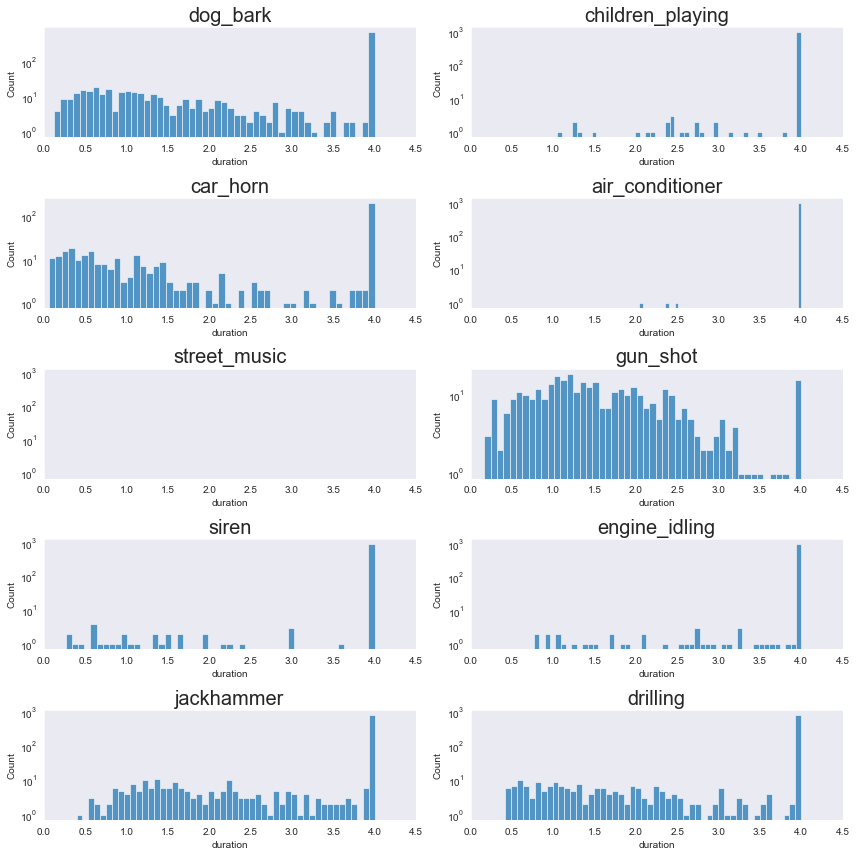

In [22]:
classes = df_meta['class'].unique()

fig, axes = plt.subplots(5,2, figsize=(12,12))
#plt.subplots_adjust(top=1.1)

for ax, class_ in zip(axes.flatten(), classes):
    sns.histplot(data=df_meta[df_meta['class'] == class_],
                 x='duration',
                 bins=50,
                 ax=ax,
                 log_scale=(False,10),
                )
    ax.set_title(class_, fontdict={'fontsize':20})
    ax.set_xlim(0, 4.5)
plt.tight_layout()

# 1. Generate audio features from audio files with the help of librosa

What we're aiming for is a dataframe:
* **rows**: all observations (audio files)
* **columns**: the audio features which we extract as numerical values from the files with librosa. They can be aggregated as statistical measures, e.g. `np.mean`, `np.std` etc.

audio_file_name | feature1 | feature 2 | ... | feature n | class
--- |--- |--- |--- |--- |---
100032-3-0-0.wav | 0.45 | -0.3 | ... | 43.23 | dog_barking
... | ... | ... | ... | ... | ...

* TODO
    * build functions for every desired audio feature to be extracted from one sound
    * define a config dictionary (later YAML?) in which user can provide which feature and which statistical metric (np.mean, np.std, etc.) she wants
    * build function which takes this config dictionary and generates the features for one sound
    * build function which builds a multidimensional array with all audio features for **all** sounds of a provided file path list and a provided config file
    * build function which generates a list of header names for all the columns of that array, with which above dataframe can be generated. Headernames can be of the form `feature_measure`, e.g. `chroma_std`.

### 1.1. Calculate features for one audio file (audio time series and sampling rate)

In [23]:
# TODO: outsource these
def calc_chroma(y, sr):
    '''
    Returns a 2d numpy.ndarray with 12 chroma features (chromagram)
    from a librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate
    '''
    return librosa.feature.chroma_stft(y=y, sr=sr)

def calc_mfcc(y, sr):
    '''
    Returns numpy.ndarray with mfcc from a
    librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate
    '''
    return librosa.feature.mfcc(y=y, sr=sr)

def calc_zcr(y, sr):
    '''
    Returns numpy.ndarray with zcr from a
    librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate
    '''
    return librosa.feature.zero_crossing_rate(y=y)

def calc_sc(y, sr):
    '''
    Returns numpy.ndarray with sc from a
    librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate 
    '''
    return librosa.feature.spectral_centroid(y=y, sr=sr)

def calc_sr(y, sr):
    '''
    Returns numpy.ndarray with sr from a
    librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate
    '''
    return librosa.feature.spectral_rolloff(y=y, sr=sr)
    
def calc_sb(y, sr):
    '''
    Returns numpy.ndarray with spectral bandwith from a
    librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate
    '''
    return librosa.feature.spectral_bandwidth(y=y, sr=sr)

def calc_rms(y, sr):
    '''
    Returns numpy.ndarray with rms from a
    librosa audio time series and a sampling rate
    
        Parameters:
            y (numpy.ndarray): librosa audio time series
            sr (int): sampling rate
    '''
    return librosa.feature.rms(y=y)

### 1.2. User flexibility: What should be calculated for every audio feature?

In [25]:
# TODO put this in a YAML or XML?
calc_config = {'chroma': {'func':calc_chroma,
                          'measures': [np.std, np.mean]
                         },
               'mfcc':{'func':calc_mfcc,
                       'measures': [np.std, np.mean]
                         },
               'zcr':{'func':calc_zcr,
                      'measures': [np.std, np.mean]
                         },
               'sc':{'func':calc_sc,
                     'measures': [np.std, np.mean]
                         },
               'sr':{'func':calc_sr,
                     'measures': [np.std, np.mean]
                         },
               'sb':{'func':calc_sb,
                     'measures': [np.std, np.mean]
                         },
               'rms':{'func':calc_rms,
                      'measures': [np.std, np.mean]
                         },
              }

Let's test it for one audio file

In [26]:
# load one audio file
y, sr = librosa.core.load(all_audio_path_list[0])

In [27]:
chrom_arr = np.mean(calc_chroma(y, sr), axis=1)

In [28]:
mfcc_arr = np.mean(calc_mfcc(y, sr), axis=1)

In [38]:
def get_column_headers_from_config(config_file):
    """
    Function to generate header names from config file
    """
    headers = []
    for k,v in config_file.items():
        for measures in v['measures']:
            headers.append(str(k) + '_' + str(measures.__name__))
    return headers 

get_column_headers_from_config(calc_config)

['chroma_std',
 'chroma_mean',
 'mfcc_std',
 'mfcc_mean',
 'zcr_std',
 'zcr_mean',
 'sc_std',
 'sc_mean',
 'sr_std',
 'sr_mean',
 'sb_std',
 'sb_mean',
 'rms_std',
 'rms_mean']

In [32]:
# function that creates a numpy array of the features of one input 
# sound. The features are calculated according to the config file
def feats_from_sound(filepath, config_file):
    y, sr =librosa.core.load(filepath)

    feature_lst = []
    
    # loop through config file entries
    for k, v in config_file.items():
        feature = v['func'](y, sr)
        for measure in v['measures']:
            feature_lst.append(measure(feature))

    return feature_lst

In [33]:
# get features for all sounds
def feats_from_sounds(audio_paths_list, config_file, show_progress=True, return_filenames=False):
    """
    calculates librosa features specified in config_file for all 
    
    """
    result_arr = []
    filenames = []
    for path in tqdm(audio_paths_list, disable=show_progress):
        result_arr.append(feats_from_sound(path, calc_config))
        filenames.append(path.split('/')[-1])
    if return_filenames:
        return np.vstack(result_arr), filenames
    else:
        return np.vstack(result_arr)

### 1.3. Generate data and column headers from config file. Build dataframe

In [34]:
# generate feature dataframe together with a list of filenames corresponding to each row
# THIS MIGHT TAKE A WHILE
feature_data, filename_lst = feats_from_sounds(all_audio_path_list, calc_config, return_filenames=True)

/home/flo/anaconda3/envs/fin-project2/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/home/flo/anaconda3/envs/fin-project2/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
/home/flo/anaconda3/envs/fin-project2/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/home/flo/anaconda3/envs/fin-project2/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


In [39]:
# get column headers according to config file
column_headers = get_column_headers_from_config(calc_config)

In [40]:
# get classes for each filename in list from meta csv.
class_lst = [get_class_from_meta(filename, df_meta) for filename in all_audio_filenames]

Check results

In [41]:
feature_data.shape

(8732, 14)

In [42]:
len(filename_lst)

8732

In [43]:
len(class_lst)

8732

#### Build the dataframe

In [44]:
# feature dataframe
df_feats = pd.DataFrame(data=feature_data, columns=column_headers)
df_feats.head()

,chroma_std,chroma_mean,mfcc_std,mfcc_mean,zcr_std,zcr_mean,sc_std,sc_mean,sr_std,sr_mean,sb_std,sb_mean,rms_std,rms_mean
0,0.306090,0.371429,103.695343,-10.487583,0.018313,0.051738,71.987518,730.361316,167.970889,1135.907582,110.704940,1066.102898,0.002671,0.015961
1,0.310757,0.577193,84.661896,-2.623090,0.037075,0.041589,453.239703,1128.429451,1142.178408,2106.208651,309.005205,1747.776761,0.040356,0.049245
2,0.288669,0.324986,37.574150,-0.397206,0.011540,0.071456,138.774597,1563.163963,357.189589,3229.420357,144.701979,1838.907310,0.025321,0.148258
3,0.296240,0.286259,61.013550,-8.226327,0.028725,0.104484,228.629427,1594.837664,446.762271,2861.239924,107.500296,1539.256136,0.025430,0.054579
4,0.294393,0.410723,59.436771,-5.889602,0.015472,0.051219,238.341885,1334.639268,704.749720,2613.919261,247.072554,1763.160701,0.037223,0.064975


In [45]:
# pickle data
pd.to_pickle(df_feats, "./data/df_feats.pkl")

# pickle filename list
pd.to_pickle(filename_lst, "./data/filename_list.pkl")

# pickle filename list
pd.to_pickle(class_lst, "./data/class_list.pkl")

In [49]:
# add filename column and class column
df_feats['filename'] = pd.read_pickle("./data/filename_list.pkl")
df_feats['class'] = pd.read_pickle("./data/class_list.pkl")

In [50]:
df_feats.head()

,chroma_std,chroma_mean,mfcc_std,mfcc_mean,zcr_std,zcr_mean,sc_std,sc_mean,sr_std,sr_mean,sb_std,sb_mean,rms_std,rms_mean,filename,class
0,0.306090,0.371429,103.695343,-10.487583,0.018313,0.051738,71.987518,730.361316,167.970889,1135.907582,110.704940,1066.102898,0.002671,0.015961,159751-8-0-8.wav,siren
1,0.310757,0.577193,84.661896,-2.623090,0.037075,0.041589,453.239703,1128.429451,1142.178408,2106.208651,309.005205,1747.776761,0.040356,0.049245,49808-3-0-6.wav,dog_bark
2,0.288669,0.324986,37.574150,-0.397206,0.011540,0.071456,138.774597,1563.163963,357.189589,3229.420357,144.701979,1838.907310,0.025321,0.148258,79377-9-0-4.wav,street_music
3,0.296240,0.286259,61.013550,-8.226327,0.028725,0.104484,228.629427,1594.837664,446.762271,2861.239924,107.500296,1539.256136,0.025430,0.054579,171165-9-0-15.wav,street_music
4,0.294393,0.410723,59.436771,-5.889602,0.015472,0.051219,238.341885,1334.639268,704.749720,2613.919261,247.072554,1763.160701,0.037223,0.064975,157940-9-0-2.wav,street_music


In [60]:
df_feats

,chroma_std,chroma_mean,mfcc_std,mfcc_mean,zcr_std,zcr_mean,sc_std,sc_mean,sr_std,sr_mean,sb_std,sb_mean,rms_std,rms_mean,filename,class
0,0.306090,0.371429,103.695343,-10.487583,0.018313,0.051738,71.987518,730.361316,167.970889,1135.907582,110.704940,1066.102898,0.002671,0.015961,159751-8-0-8.wav,siren
1,0.310757,0.577193,84.661896,-2.623090,0.037075,0.041589,453.239703,1128.429451,1142.178408,2106.208651,309.005205,1747.776761,0.040356,0.049245,49808-3-0-6.wav,dog_bark
2,0.288669,0.324986,37.574150,-0.397206,0.011540,0.071456,138.774597,1563.163963,357.189589,3229.420357,144.701979,1838.907310,0.025321,0.148258,79377-9-0-4.wav,street_music
3,0.296240,0.286259,61.013550,-8.226327,0.028725,0.104484,228.629427,1594.837664,446.762271,2861.239924,107.500296,1539.256136,0.025430,0.054579,171165-9-0-15.wav,street_music
4,0.294393,0.410723,59.436771,-5.889602,0.015472,0.051219,238.341885,1334.639268,704.749720,2613.919261,247.072554,1763.160701,0.037223,0.064975,157940-9-0-2.wav,street_music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,0.199295,0.668079,36.595741,1.432799,0.034128,0.098904,892.026976,1986.422253,2096.267795,3932.112254,734.912444,1916.525338,0.056681,0.205395,135528-6-4-0.wav,gun_shot
8728,0.252415,0.530090,48.599316,-4.030933,0.018071,0.084481,274.232048,1860.298246,1140.073660,4065.418962,259.869557,2364.612191,0.013139,0.047411,7389-1-4-3.wav,car_horn
8729,0.285845,0.257517,70.925354,-10.283336,0.012202,0.050714,308.664231,1213.787505,887.852283,2383.650904,324.403005,1567.997381,0.008176,0.044566,155044-9-0-3.wav,street_music
8730,0.289686,0.377840,44.384869,1.069430,0.036968,0.113949,457.640352,2215.589252,1221.521792,4519.439338,320.212606,2272.645654,0.034292,0.064423,24076-1-1-0.wav,car_horn


In [61]:
# save to pickle
pd.to_pickle(df_feats, "./data/df_feats.pkl")

### (Not necessary for random forest) Apply standard scaler - also only scale training data - move this to preprocessing or delete

In [46]:
df_feats = pd.read_pickle("./data/df_feats.pkl")

In [47]:
df_feats.head()

,chroma_std,chroma_mean,mfcc_std,mfcc_mean,zcr_std,zcr_mean,sc_std,sc_mean,sr_std,sr_mean,sb_std,sb_mean,rms_std,rms_mean
0,0.306090,0.371429,103.695343,-10.487583,0.018313,0.051738,71.987518,730.361316,167.970889,1135.907582,110.704940,1066.102898,0.002671,0.015961
1,0.310757,0.577193,84.661896,-2.623090,0.037075,0.041589,453.239703,1128.429451,1142.178408,2106.208651,309.005205,1747.776761,0.040356,0.049245
2,0.288669,0.324986,37.574150,-0.397206,0.011540,0.071456,138.774597,1563.163963,357.189589,3229.420357,144.701979,1838.907310,0.025321,0.148258
3,0.296240,0.286259,61.013550,-8.226327,0.028725,0.104484,228.629427,1594.837664,446.762271,2861.239924,107.500296,1539.256136,0.025430,0.054579
4,0.294393,0.410723,59.436771,-5.889602,0.015472,0.051219,238.341885,1334.639268,704.749720,2613.919261,247.072554,1763.160701,0.037223,0.064975


In [48]:
# scaler = StandardScaler()
# scaler.fit(df_feats)
# arr_feats = scaler.transform(df_feats)
# df_feats = pd.DataFrame(data=arr_feats, columns=column_headers)
# df_feats.head()

# EDA (features need to be scaled first, but only the training part)

Function to generate boxplots for each feature of each class

In [51]:
def plot_boxplots_for_classes(class_):
    sns.set(rc={'figure.figsize':(14,8)})
    g = sns.boxplot(x="variable",
                    y="value",
                    data=pd.melt(df_feats[df_feats['class']==class_].drop(['filename','class'], axis=1)),
                    fliersize=1);
    g.set_xticklabels(g.get_xticklabels(),
                      rotation=90,
                     );
    g.set_xlabel('feature');
    g.set_ylabel('value');
    g.set_title(class_, fontdict={'fontsize':20})
    plt.show()

### generate the boxplots

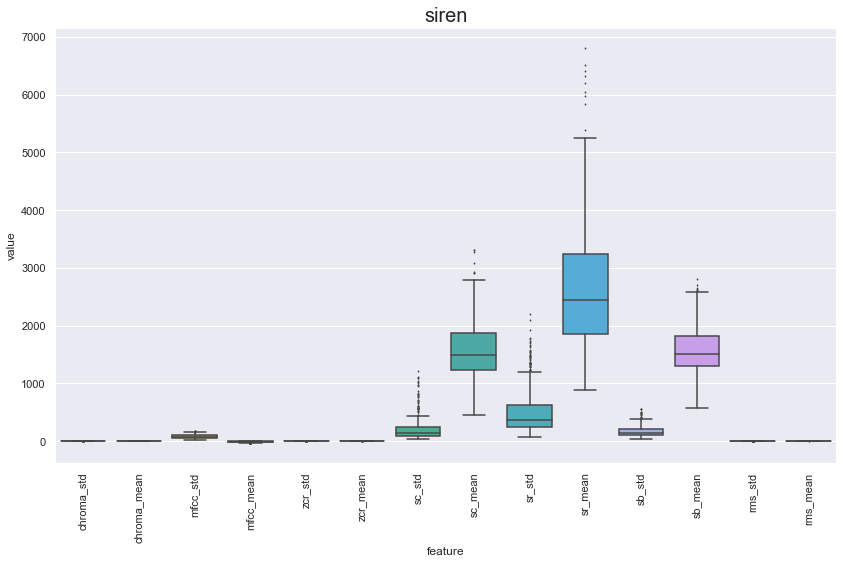

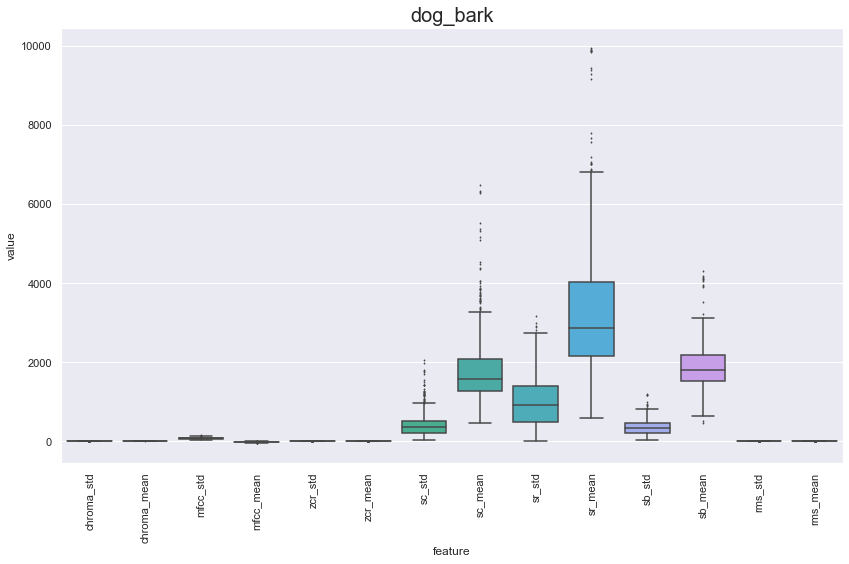

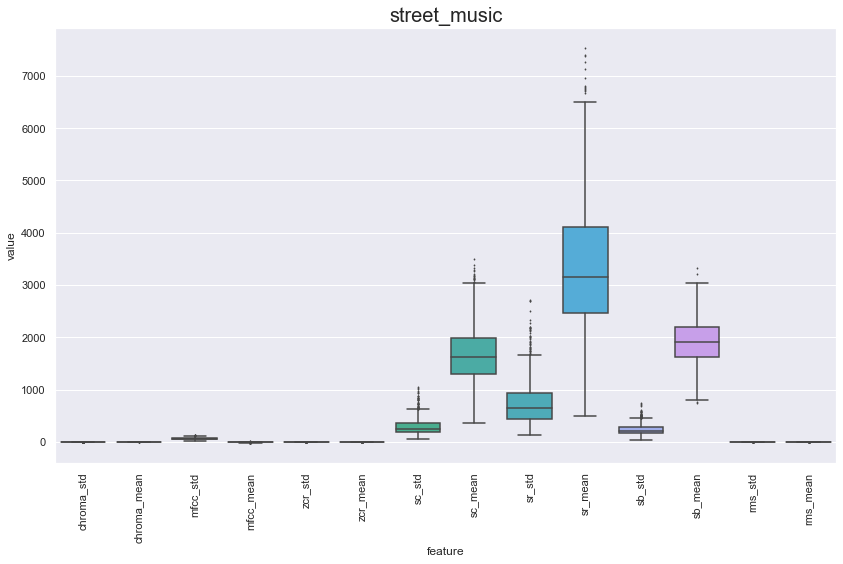

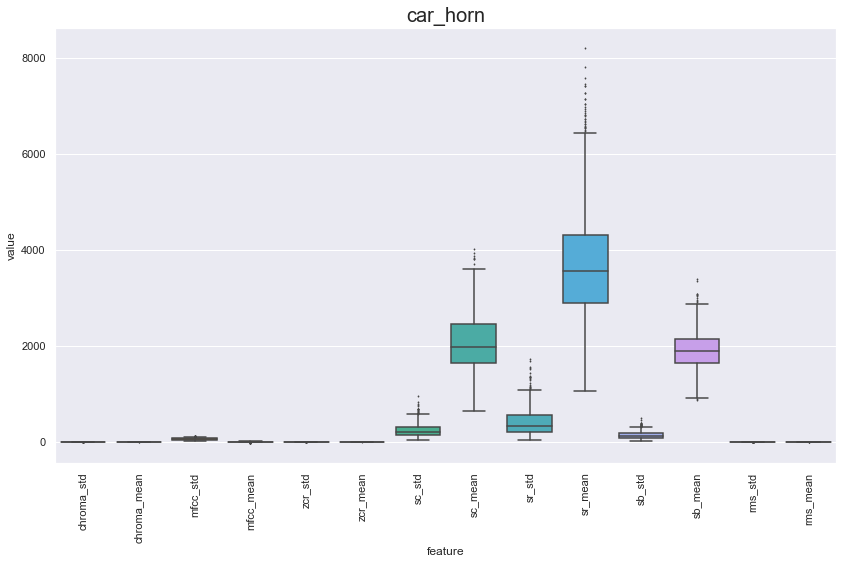

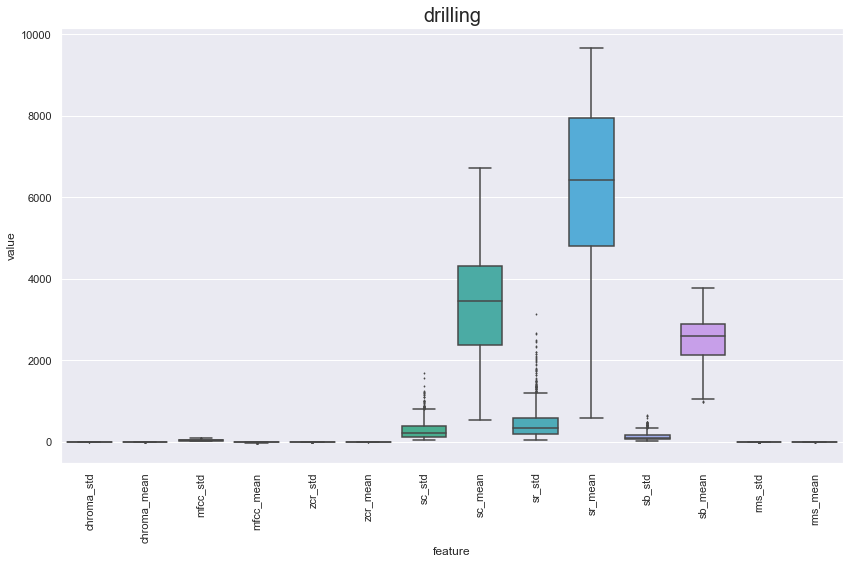

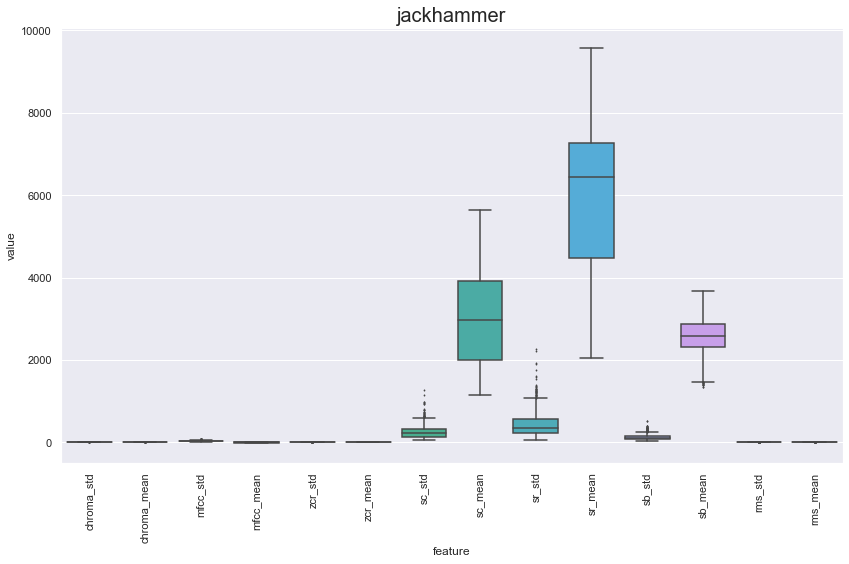

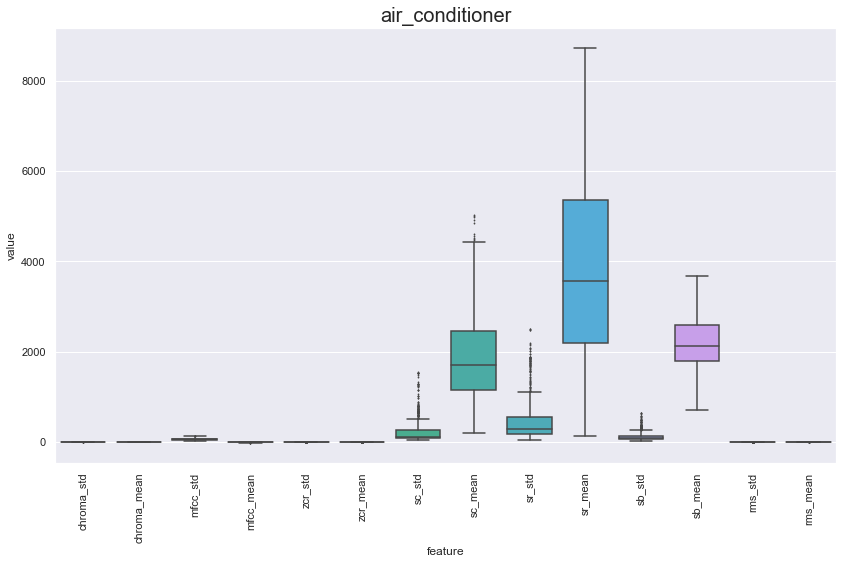

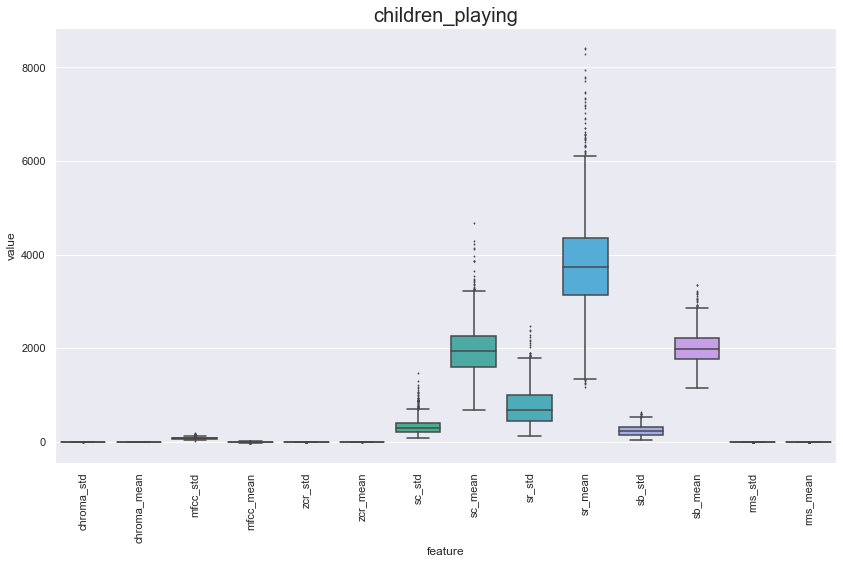

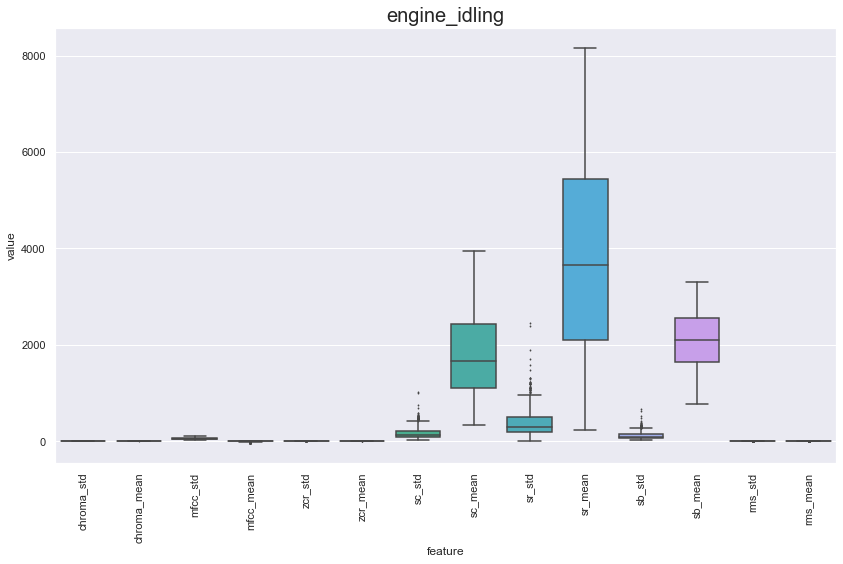

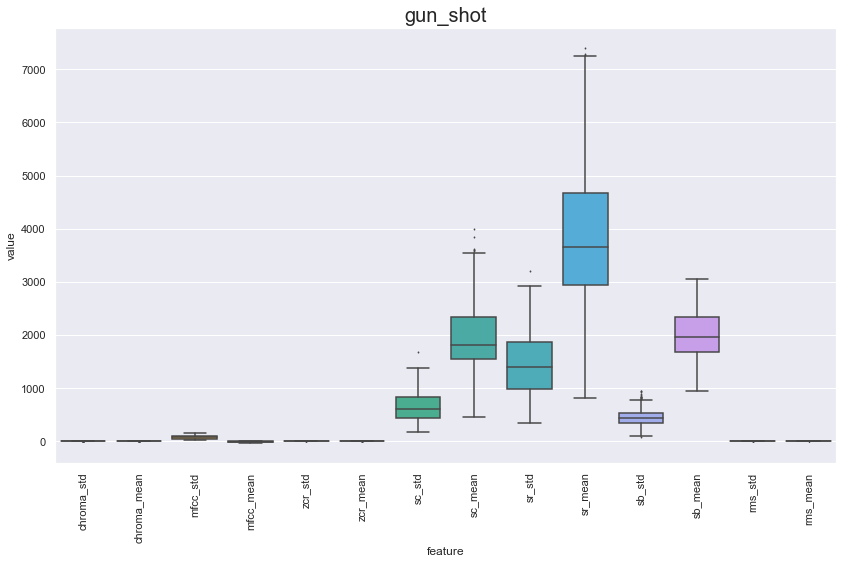

In [53]:
[plot_boxplots_for_classes(class_) for class_ in df_feats['class'].unique()];

In [54]:
df_feats_melt = pd.melt(df_feats.drop(['filename'], axis=1), id_vars='class').rename(columns={'variable':'feature'})

In [55]:
df_feats_melt.head()

,class,feature,value
0,siren,chroma_std,0.306090
1,dog_bark,chroma_std,0.310757
2,street_music,chroma_std,0.288669
3,street_music,chroma_std,0.296240
4,street_music,chroma_std,0.294393


### Boxplots for each class next to each other per feature

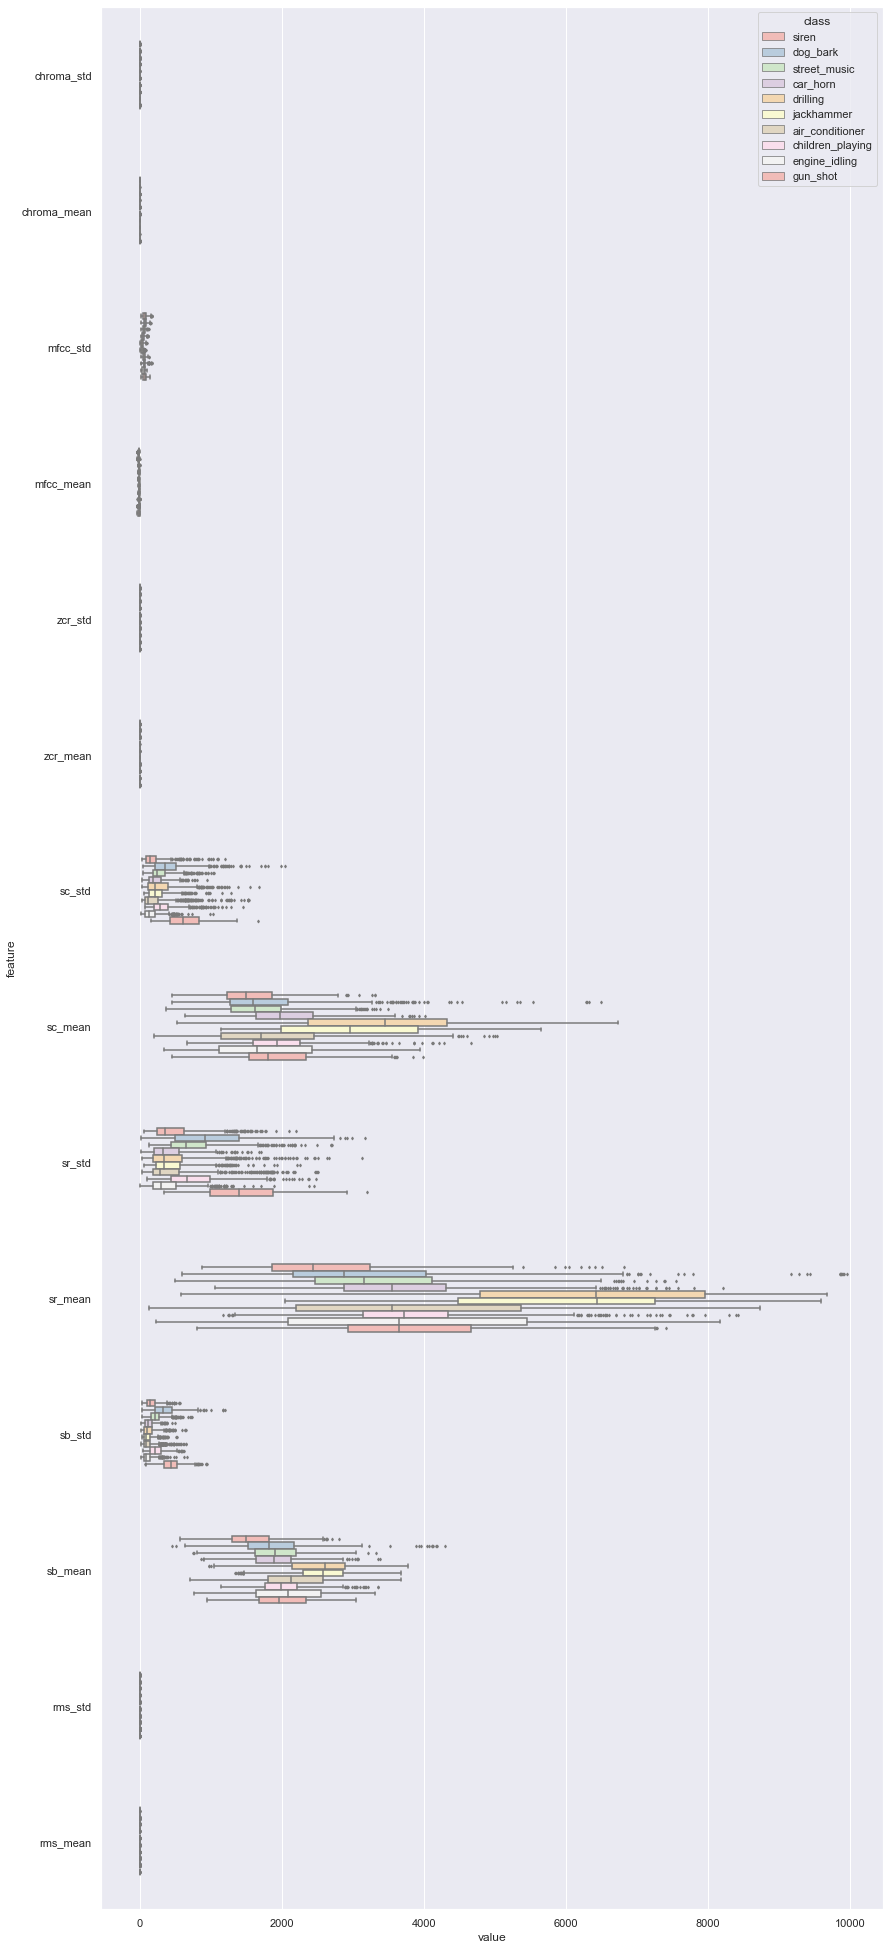

In [56]:
sns.set(rc={'figure.figsize':(14,35)})
sns.boxplot(y="feature",
            x="value",
            hue="class",
            data=df_feats_melt,
            palette="Pastel1",
            fliersize=2,
            width=.5,
           )
plt.show()

# 2. Predict the class!

### Random forest, first iteration

In [62]:
df = pd.read_pickle("./data/df_feats.pkl")

In [63]:
df.head()

,chroma_std,chroma_mean,mfcc_std,mfcc_mean,zcr_std,zcr_mean,sc_std,sc_mean,sr_std,sr_mean,sb_std,sb_mean,rms_std,rms_mean,filename,class
0,0.306090,0.371429,103.695343,-10.487583,0.018313,0.051738,71.987518,730.361316,167.970889,1135.907582,110.704940,1066.102898,0.002671,0.015961,159751-8-0-8.wav,siren
1,0.310757,0.577193,84.661896,-2.623090,0.037075,0.041589,453.239703,1128.429451,1142.178408,2106.208651,309.005205,1747.776761,0.040356,0.049245,49808-3-0-6.wav,dog_bark
2,0.288669,0.324986,37.574150,-0.397206,0.011540,0.071456,138.774597,1563.163963,357.189589,3229.420357,144.701979,1838.907310,0.025321,0.148258,79377-9-0-4.wav,street_music
3,0.296240,0.286259,61.013550,-8.226327,0.028725,0.104484,228.629427,1594.837664,446.762271,2861.239924,107.500296,1539.256136,0.025430,0.054579,171165-9-0-15.wav,street_music
4,0.294393,0.410723,59.436771,-5.889602,0.015472,0.051219,238.341885,1334.639268,704.749720,2613.919261,247.072554,1763.160701,0.037223,0.064975,157940-9-0-2.wav,street_music


In [64]:
X = df.drop(['filename', 'class'], axis=1)
y = df['class']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

For the first iteration, let's choose the standard RandomForestClassifier with default values
* `n_estimators=100`,
* `criterion='gini'`,
* `max_depth=None`,
* `min_samples_split=2`,
* `min_samples_leaf=1`,
* `min_weight_fraction_leaf=0.0`,
* `max_features='auto'`,
* `max_leaf_nodes=None`,
* `min_impurity_decrease=0.0`,
* `min_impurity_split=None`,
* `bootstrap=True`,
* `oob_score=False`,
* `n_jobs=None`,
* `random_state=None`,
* `verbose=0`,
* `warm_start=False`,
* `class_weight=None`,
* `ccp_alpha=0.0`,
* `max_samples=None`,

In [74]:
forest_clf = RandomForestClassifier(random_state=42)

In [75]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
y_pred = forest_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.8213046495489243

In [69]:
y_labels = list(y_test.unique())

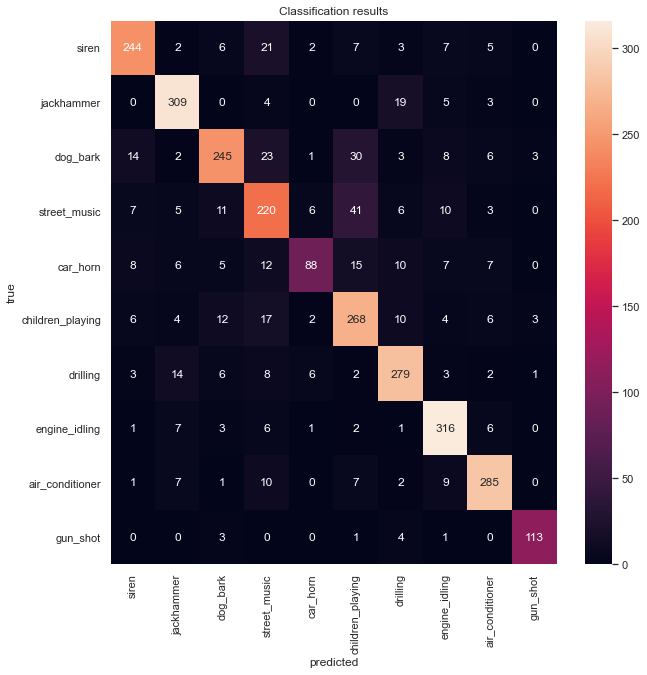

In [70]:
# calculate the confusion matrix
cnf_mat = confusion_matrix(y_test, y_pred, labels=y_labels)

# plot
sns.set(rc={'figure.figsize':(10,10)})
g = sns.heatmap(cnf_mat,
            annot=True,
            fmt='d',
            xticklabels=y_labels,
            yticklabels=y_labels,
           );
g.set_title("Classification results");
g.set_xlabel("predicted");
g.set_ylabel("true");

Observations:
* With an accuracy score of 82% for the test data, this is already a fairly decent model

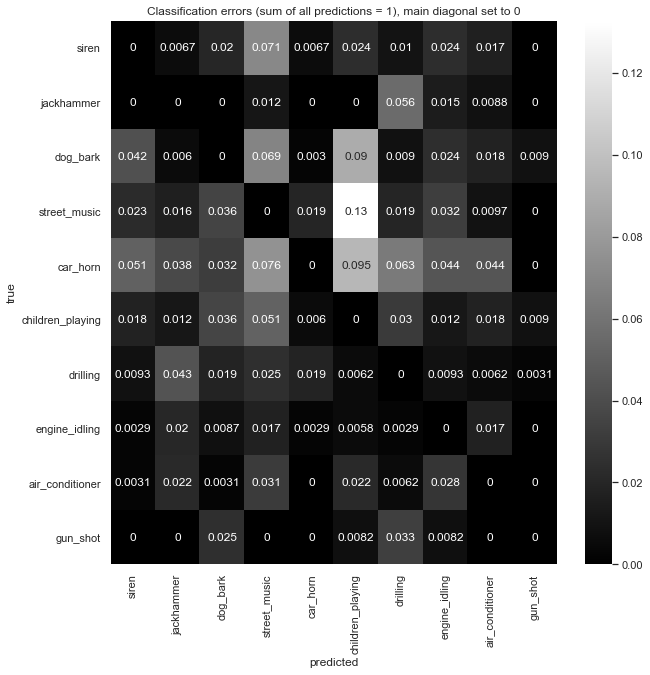

In [81]:
row_sums = cnf_mat.sum(axis=1, keepdims=True)
norm_cnf_mat = cnf_mat / row_sums

# fill diagonal with zeros
np.fill_diagonal(norm_cnf_mat, 0)
g = sns.heatmap(norm_cnf_mat,
            annot=True,
            #fmt='d',
            xticklabels=y_labels,
            yticklabels=y_labels,
                cmap=plt.cm.gray,
           );
g.set_title("Classification errors (sum of all predictions = 1), main diagonal set to 0");
g.set_xlabel("predicted");
g.set_ylabel("true");

What we can observe here: `dog_bark`, `street_music` and `car_horn` is relatively often mistaken by the model as `children_playing`. 
* **TODO** So let's look at those features specifically and try to find something that distinguishes them

In [51]:
df_selected = df_feats_melt[df_feats_melt['class'].isin(['dog_bark', 'street_music', 'car_horn', 'children_playing'])]

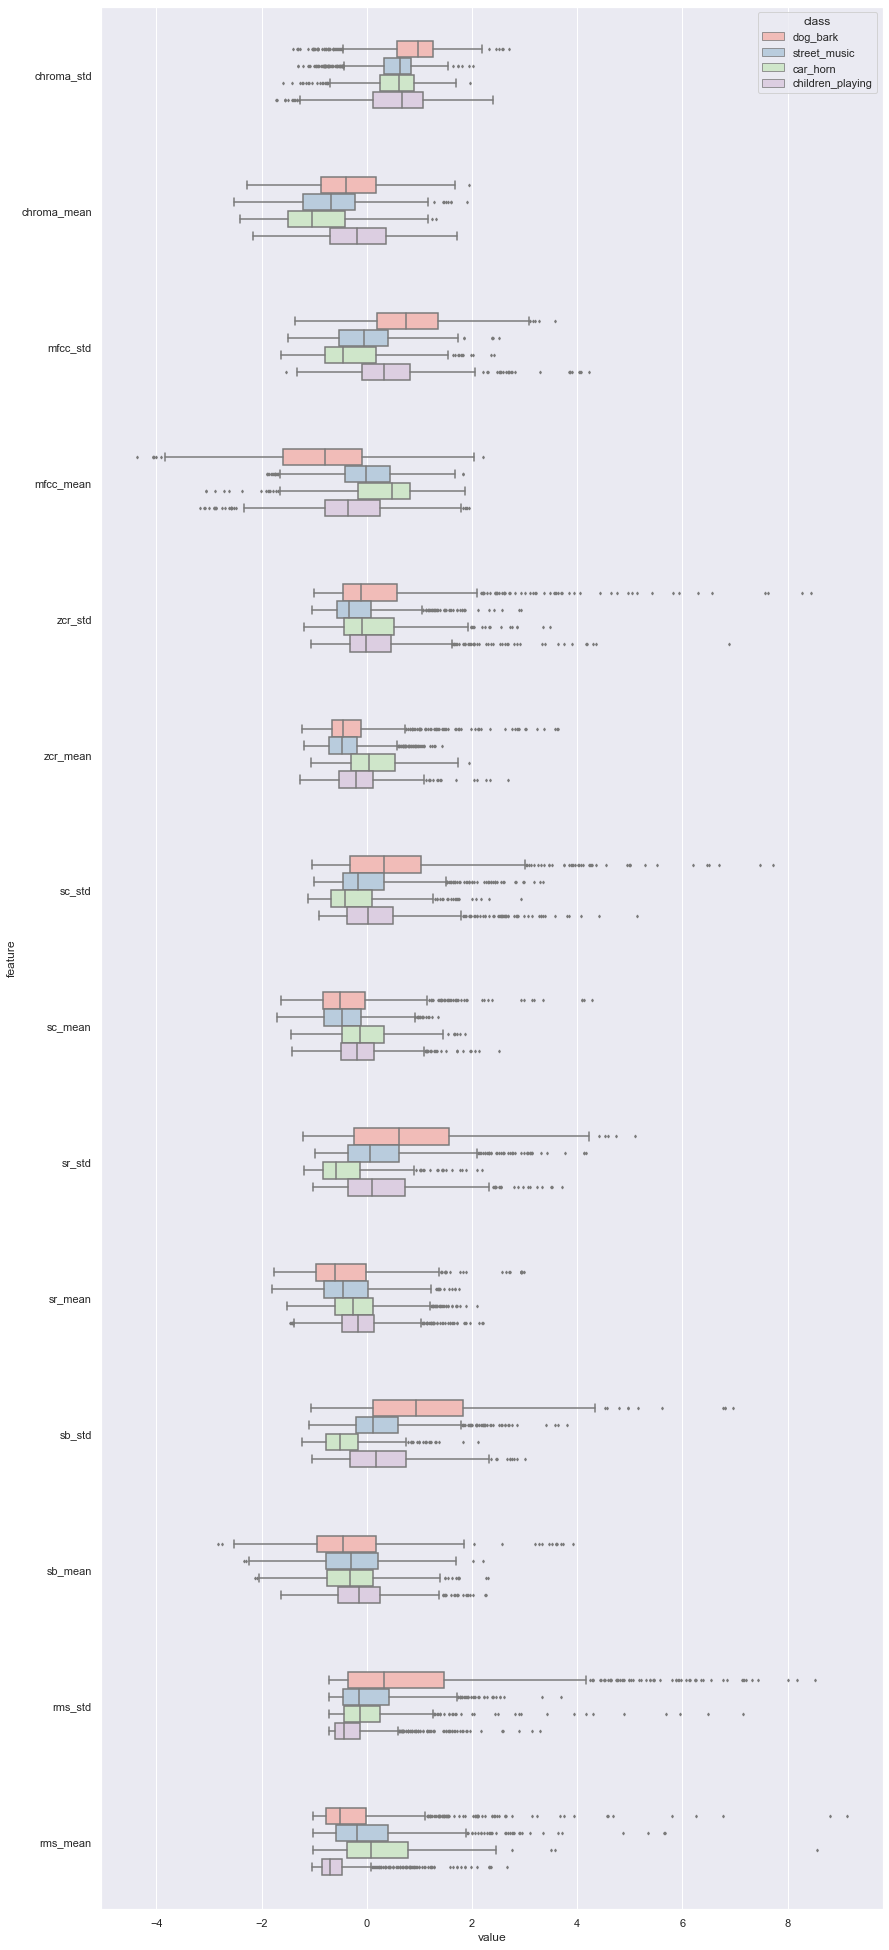

In [52]:
sns.set(rc={'figure.figsize':(14,35)})
sns.boxplot(y="feature",
            x="value",
            hue="class",
            data=df_selected,
            palette="Pastel1",
            fliersize=2,
            width=.5,
           )
plt.show()

* high overlap in `chroma_std`, `zcr_std`, `sc_mean`, `sr_mean`, `sb_mean`

In [56]:
import matplotlib.pyplot as plt

from collections import OrderedDict

RANDOM_STATE = 123

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
#    ("RandomForestClassifier, max_features=None",
#        RandomForestClassifier(warm_start=True, max_features=None,
#                               oob_score=True,
#                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 400
max_estimators = 3000

for label, clf in ensemble_clfs:
    for i in tqdm(range(min_estimators, max_estimators + 1)):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

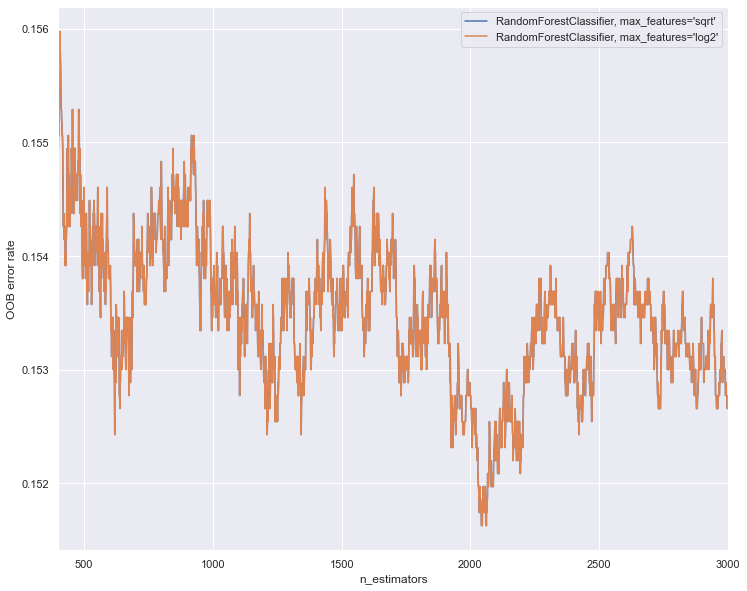

In [57]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
sns.set(rc={'figure.figsize':(12,10)})
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [71]:
pd.to_pickle(ensemble_clfs, './data/ensemble_clfs_sqrt_log2.pkl')

In [72]:
pd.to_pickle(error_rate, "./data/error_rate_ordered_dct.pkl")

What's the number of estimators with the minimum error rate?

In [88]:
import operator
min([err for _, clf_err in error_rate.items() for err in clf_err], key=operator.itemgetter(1))

(2043, 0.1516262024736601)

Let's use 2043 then as the `n_estimators` parameter

In [91]:
rfc_tuned = RandomForestClassifier(max_features="sqrt",random_state=RANDOM_STATE, n_estimators=2043)
rfc_tuned.fit(X_train, y_train)
y_pred = rfc_tuned.predict(X_test)

accuracy_score(y_test, y_pred)

0.8303261623872311

2 percent increase \o/

## 2.1. Model optimization approaches

* Hyperparameter tuning (ensemble methods, number of trees etc. ...)
* Feature inspection: Why are some classes confused with some specific classes more than with others. Generate features that distinguish them
* Build a *hard-voting-classifier* out of several algorithms - Predictions are then majority votes (`from sklearn.ensemble import VotingClassifier`)

In [ ]:
librosa.display.specshow()